<a href="https://colab.research.google.com/github/qkrwoghd04/ImageCaptionnng_Using_ViT/blob/master/practice/Vision_Transformer_Architecture_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ViT Architecture Practice

Distinguishing between a person **sleeping** and a person **falling down**


In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install --upgrade keras

In [3]:
# !pip install ops

## Initialization

In [44]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import keras as keras
from keras import ops

# 모델 파일 경로
model_path = r'/content/drive/MyDrive/Fall_vs_Sleep_ViTmodel.keras'

#hyperparameter
input_shape = (32,32,3)
batch_size = 64
epochs = 30
lr = 3e-5
gamma = 0.7
seed = 142
image_size = 224
patch_size = 16
num_classes = 2
weight_decay = 0.004

In [79]:
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# 이미지와 레이블을 저장할 리스트 초기화
x_train = []
y_train = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = r'/content/drive/MyDrive/image_dataset_splited/train'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_train.append(img_array)
        y_train.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_train = np.array(x_train)
y_train = np.array(y_train)


# 데이터 차원 출력
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")


x_train: (320, 32, 32, 3), y_train: (320,)


In [80]:
# 이미지와 레이블을 저장할 리스트 초기화
x_val = []
y_val = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = r'/content/drive/MyDrive/image_dataset_splited/val'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_val.append(img_array)
        y_val.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_val = np.array(x_val)
y_val = np.array(y_val)


# 데이터 차원 출력
print(f"x_val: {x_train.shape}, y_val: {y_train.shape}")


Fall
Sleep
x_val: (320, 32, 32, 3), y_val: (320,)


In [81]:
x_test = []
y_test = []

# 클래스별로 폴더 경로 설정
classes = ['Fall', 'Sleep']
class_labels = {'Fall': 0, 'Sleep': 1}

base_path = '/content/drive/MyDrive/image_dataset_splited/test'

for class_name in classes:
    class_dir = os.path.join(base_path, class_name)
    for img_name in os.listdir(class_dir):
        # 이미지 로드 및 리사이즈
        img_path = os.path.join(class_dir, img_name)
        img = load_img(img_path, target_size=(input_shape))
        img_array = img_to_array(img)

        # 이미지와 레이블 리스트에 추가
        x_test.append(img_array)
        y_test.append(class_labels[class_name])

# 리스트를 NumPy 배열로 변환
x_test = np.array(x_test)
y_test = np.array(y_test)


# 데이터 차원 출력
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")


x_test: (40, 32, 32, 3), y_test: (40,)


In [66]:
num_patches = (image_size//patch_size)**2

# D
projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim*2,
    projection_dim,
]

transformer_layers = 12
mlp_head_units = [2048, 1024]

In [67]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),

    ],
    name = 'data_augmentation',
)
data_augmentation.layers[0].adapt(x_train)

In [68]:
def mlp(x, hidden_units, dropout_rate):


  for units in hidden_units:
    x = layers.Dense(units,activation=tf.nn.gelu)(x) #GELU(Gaussian Error Linear Unit)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [69]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768
Shape of patch: (1, 196, 768)


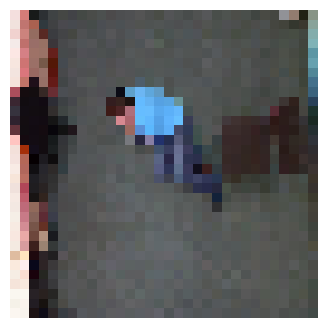

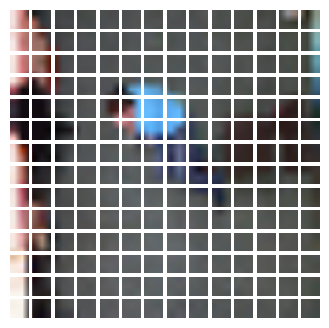

In [70]:
# @title
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(f"Shape of patch: {patches.shape}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [71]:
class PatchEncoder(layers.Layer):
  def __init__(self, num_patches, projection_dim):
    super().__init__()
    self.num_patches = num_patches

    self.projection = layers.Dense(units=projection_dim)
    self.position_embedding = layers.Embedding(
        input_dim = num_patches, output_dim = projection_dim
    )

  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [72]:
def vit():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(2, activation='softmax')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [82]:
model = vit()
model.summary()

Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ data_augmentation         │ (None, 224, 224, 3)    │              7 │ input_layer_7[0][0]    │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patches_8 (Patches)       │ (None, 196, 768)       │              0 │ data_augmentation[2][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ patch_encoder_5           │ (None, 196, 64)        │         61,760 │ patches_8[0][0]        │
│ (PatchEncoder)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_125   │ (None, 196, 64)        │            128 │ patch_encoder_5[0][0]  │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_60   │ (None, 196, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_120 (Add)             │ (None, 196, 64)        │              0 │ multi_head_attention_… │
│                           │                        │                │ patch_encoder_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_126   │ (None, 196, 64)        │            128 │ add_120[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_141 (Dense)         │ (None, 196, 128)       │          8,320 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_196 (Dropout)     │ (None, 196, 128)       │              0 │ dense_141[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_142 (Dense)         │ (None, 196, 64)        │          8,256 │ dropout_196[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_197 (Dropout)     │ (None, 196, 64)        │              0 │ dense_142[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_121 (Add)             │ (None, 196, 64)        │              0 │ dropout_197[0][0],     │
│                           │                        │                │ add_120[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_127   │ (None, 196, 64)        │            128 │ add_121[0][0]          │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_61   │ (None, 196, 64)        │         66,368 │ layer_normalization_1… │
│ (MultiHeadAttention) 

 Total params: 28,852,681 (110.06 MB)

 Trainable params: 28,852,674 (110.06 MB)

 Non-trainable params: 7 (32.00 B)

In [83]:
optimizer = keras.optimizers.AdamW(
        learning_rate=lr, weight_decay=weight_decay
    )

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = "drive/MyDrive/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

class_weight = {0: 1., 1: 5.}

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[checkpoint_callback],
    class_weight=class_weight
)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.5149 - loss: 5.3744 - val_accuracy: 0.5000 - val_loss: 1.3570
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - accuracy: 0.5703 - loss: 2.7674 - val_accuracy: 0.5000 - val_loss: 1.6675
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5397 - loss: 2.7527 - val_accuracy: 0.5750 - val_loss: 1.1191
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.5879 - loss: 2.2946 - val_accuracy: 0.6625 - val_loss: 0.7712
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step - accuracy: 0.6186 - loss: 2.3792 - val_accuracy: 0.6875 - val_loss: 0.7026
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6705 - loss: 1.8236 - val_accuracy: 0.7000 - val_loss: 0.6709
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.6843 - loss: 1.8671 - val_accuracy: 0.7000 - val_loss: 0.6286
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step - accuracy: 0.6849 - loss: 1.6466 - val_accuracy: 0.7250 - val_loss: 0.6092


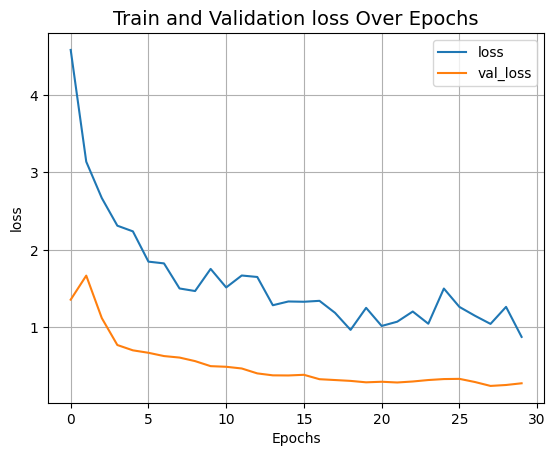

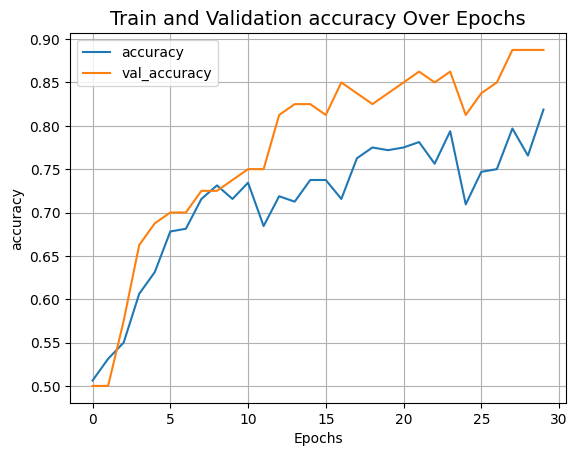

In [84]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

In [23]:
model_path = '/content/drive/MyDrive/Fall_vs_Sleep_ViTmodel.keras'
model.save(model_path)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


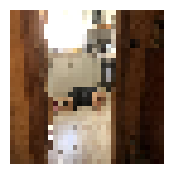

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 99.12%
Probability of being 'Sleep': 0.88%
Prediction: Correct
-----------------------------------------------------


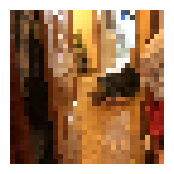

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 53.37%
Probability of being 'Sleep': 46.63%
Prediction: Correct
-----------------------------------------------------


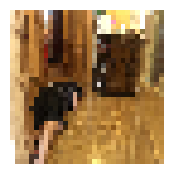

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 7.40%
Probability of being 'Sleep': 92.60%
Prediction: Incorrect
-----------------------------------------------------


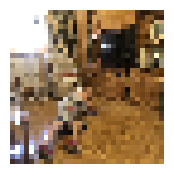

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 45.01%
Probability of being 'Sleep': 54.99%
Prediction: Incorrect
-----------------------------------------------------


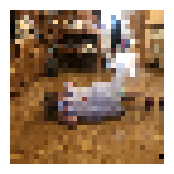

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 70.07%
Probability of being 'Sleep': 29.93%
Prediction: Correct
-----------------------------------------------------


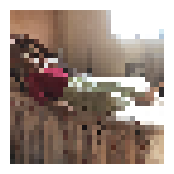

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 90.15%
Probability of being 'Sleep': 9.85%
Prediction: Correct
-----------------------------------------------------


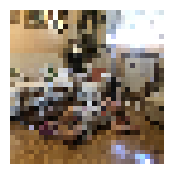

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 98.52%
Probability of being 'Sleep': 1.48%
Prediction: Correct
-----------------------------------------------------


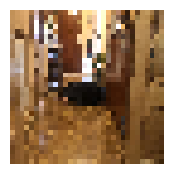

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 85.59%
Probability of being 'Sleep': 14.41%
Prediction: Correct
-----------------------------------------------------


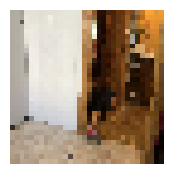

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 70.39%
Probability of being 'Sleep': 29.61%
Prediction: Correct
-----------------------------------------------------


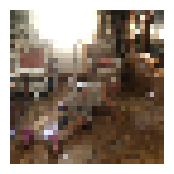

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 88.66%
Probability of being 'Sleep': 11.34%
Prediction: Correct
-----------------------------------------------------


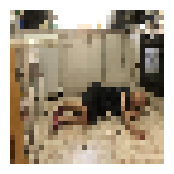

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 96.59%
Probability of being 'Sleep': 3.41%
Prediction: Correct
-----------------------------------------------------


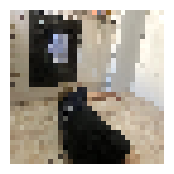

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 8.84%
Probability of being 'Sleep': 91.16%
Prediction: Incorrect
-----------------------------------------------------


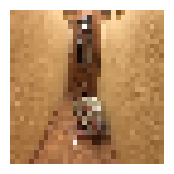

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 24.67%
Probability of being 'Sleep': 75.33%
Prediction: Incorrect
-----------------------------------------------------


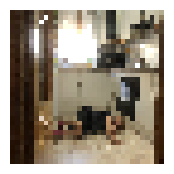

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 94.97%
Probability of being 'Sleep': 5.03%
Prediction: Correct
-----------------------------------------------------


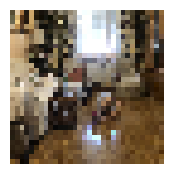

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 99.53%
Probability of being 'Sleep': 0.47%
Prediction: Correct
-----------------------------------------------------


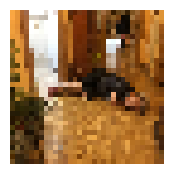

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 58.07%
Probability of being 'Sleep': 41.93%
Prediction: Correct
-----------------------------------------------------


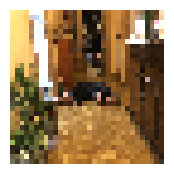

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 38.58%
Probability of being 'Sleep': 61.42%
Prediction: Incorrect
-----------------------------------------------------


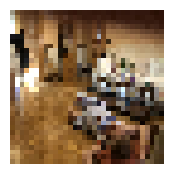

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 45.11%
Probability of being 'Sleep': 54.89%
Prediction: Incorrect
-----------------------------------------------------


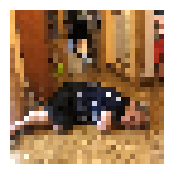

Actual class: Fall | Predicted class: Sleep
Probability of being 'Fall': 49.82%
Probability of being 'Sleep': 50.18%
Prediction: Incorrect
-----------------------------------------------------


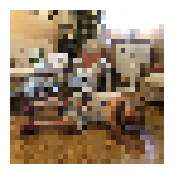

Actual class: Fall | Predicted class: Fall
Probability of being 'Fall': 88.87%
Probability of being 'Sleep': 11.13%
Prediction: Correct
-----------------------------------------------------


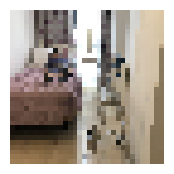

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.91%
Probability of being 'Sleep': 0.09%
Prediction: Incorrect
-----------------------------------------------------


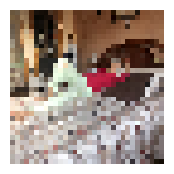

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 65.28%
Probability of being 'Sleep': 34.72%
Prediction: Incorrect
-----------------------------------------------------


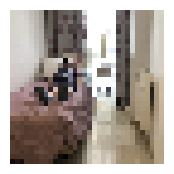

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.73%
Probability of being 'Sleep': 0.27%
Prediction: Incorrect
-----------------------------------------------------


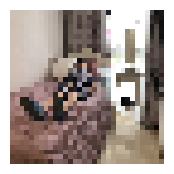

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 80.73%
Probability of being 'Sleep': 19.27%
Prediction: Incorrect
-----------------------------------------------------


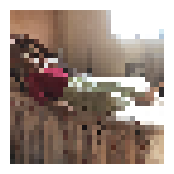

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 90.15%
Probability of being 'Sleep': 9.85%
Prediction: Incorrect
-----------------------------------------------------


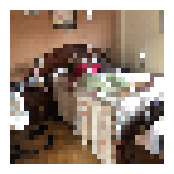

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 73.61%
Probability of being 'Sleep': 26.39%
Prediction: Incorrect
-----------------------------------------------------


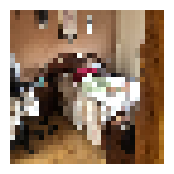

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 84.56%
Probability of being 'Sleep': 15.44%
Prediction: Incorrect
-----------------------------------------------------


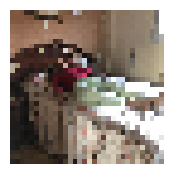

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 77.75%
Probability of being 'Sleep': 22.25%
Prediction: Incorrect
-----------------------------------------------------


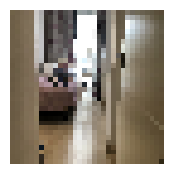

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.69%
Probability of being 'Sleep': 0.31%
Prediction: Incorrect
-----------------------------------------------------


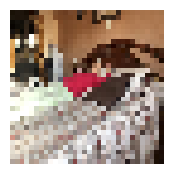

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 77.06%
Probability of being 'Sleep': 22.94%
Prediction: Incorrect
-----------------------------------------------------


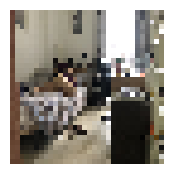

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 97.29%
Probability of being 'Sleep': 2.71%
Prediction: Incorrect
-----------------------------------------------------


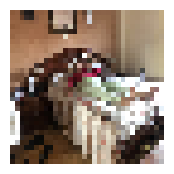

Actual class: Sleep | Predicted class: Sleep
Probability of being 'Fall': 33.51%
Probability of being 'Sleep': 66.49%
Prediction: Correct
-----------------------------------------------------


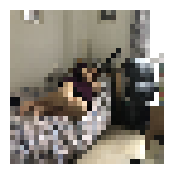

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 89.67%
Probability of being 'Sleep': 10.33%
Prediction: Incorrect
-----------------------------------------------------


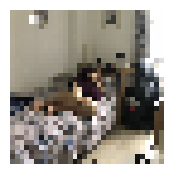

Actual class: Sleep | Predicted class: Sleep
Probability of being 'Fall': 46.09%
Probability of being 'Sleep': 53.91%
Prediction: Correct
-----------------------------------------------------


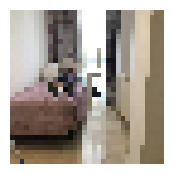

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.87%
Probability of being 'Sleep': 0.13%
Prediction: Incorrect
-----------------------------------------------------


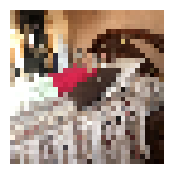

Actual class: Sleep | Predicted class: Sleep
Probability of being 'Fall': 41.78%
Probability of being 'Sleep': 58.22%
Prediction: Correct
-----------------------------------------------------


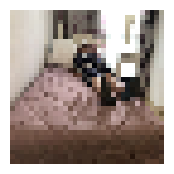

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.51%
Probability of being 'Sleep': 0.49%
Prediction: Incorrect
-----------------------------------------------------


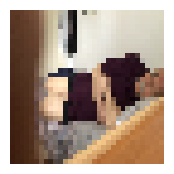

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 99.14%
Probability of being 'Sleep': 0.86%
Prediction: Incorrect
-----------------------------------------------------


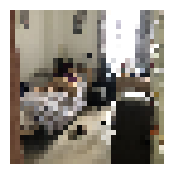

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 92.24%
Probability of being 'Sleep': 7.76%
Prediction: Incorrect
-----------------------------------------------------


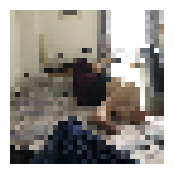

Actual class: Sleep | Predicted class: Fall
Probability of being 'Fall': 51.01%
Probability of being 'Sleep': 48.99%
Prediction: Incorrect
-----------------------------------------------------
Total accuracy: 40.00%


In [89]:
# x_test 데이터셋에 대한 예측 수행
predictions = model.predict(x_test)
class_names = ['Fall', 'Sleep']
correct_predictions = 0
total_predictions = len(x_test)
# 결과 출력
# 결과 및 예측 성공 여부 출력
for i in range(len(x_test)):
    # 예측 확률 계산
    fall_probability = predictions[i][0]
    sleep_probability = 1 - fall_probability if len(predictions[i]) == 1 else predictions[i][1]

    # 예측된 클래스 인덱스
    predicted_class_index = np.argmax(predictions[i])

    # 실제 클래스와 비교
    actual_class = "Sleep" if y_test[i] == 1 else "Fall"
    predicted_class = class_names[predicted_class_index]
    is_correct = "Correct" if predicted_class == actual_class else "Incorrect"
    if(is_correct == "Correct"):
        correct_predictions += 1

    # 정확도 계산
    total_accuracy = correct_predictions / total_predictions * 100

    # 이미지 시각화
    plt.figure(figsize=(2,2))
    plt.imshow(x_test[i].astype("uint8"))
    plt.axis('off')
    plt.show()

    # 예측 결과 및 확률 출력
    print(f"Actual class: {actual_class} | Predicted class: {predicted_class}")
    print(f"Probability of being 'Fall': {fall_probability * 100:.2f}%")
    print(f"Probability of being 'Sleep': {sleep_probability * 100:.2f}%")
    print(f"Prediction: {is_correct}")
    print("-----------------------------------------------------")
print(f"Total accuracy: {total_accuracy:.2f}%")